# Learning the committor
Reference paper: 
_Kang, Trizio and Parrinello, [Nat Comput Sci](https://doi.org/10.1038/s43588-024-00645-0) (2024), [ArXiv](https://arxiv.org/abs/2401.05279)_

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/committor/docs/notebooks/tutorials/cvs_committor.ipynb)


## Introduction

Given an a system presenting two metastable states $A$ and $B$, the commmittor $q(\mathbf{x})$ is a function that for each configuration $\mathbf{x}$gives the probability that it will evolve to $B$ before having passed through $A$.

One way to learn the committor function is to leverage the variational principle introduced by Kolmogorov, which amounts to satisfying the boundary conditions
$$ q(\mathbf{x}_A) = 0 \quad \text{and} \quad  q(\mathbf{x}_B) = 1$$
to minimizing the functional $K[q(\mathbf{x})]$ of the committor
$$ K[q(\mathbf{x})] \quad=\quad \frac{1}{Z} \int | \nabla_u q(\mathbf{x})|^2 e^{-\beta U (\mathbf{x})} d \mathbf{x} \quad=\quad  \langle | \nabla_u q(\mathbf{x})|^2  \rangle_{U (\mathbf{x})}$$
where $\nabla_u$ denotes the gradient wrt the mass-scaled Cartesian coordinates, $Z$ is the partition function function associated to the potential $U(\mathbf(x))$ and the last term represent the ensemble average over the corresponding Boltzmann ensemble.
 
 

## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

## Initialize committor model and training variables

In [25]:
from mlcolvar.cvs.committor import Committor,initialize_committor_masses

# temperature
T = 1 
# Boltzmann factor in the RIGHT ENREGY UNITS!
kb = 1
beta = 1/(kb*T)
print(f'Beta: {beta} \n1/beta: {1/beta}')

atomic_masses = initialize_committor_masses(atom_types=[0], masses=[1], n_dims=2)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR
options = {'optimizer' : {'lr': 1e-3, 'weight_decay': 1e-5}, 
           'lr_scheduler' : { 'scheduler' : lr_scheduler, 'gamma' : 0.99999 }}

model = Committor(layers=[2, 32, 32, 1],
                    mass=atomic_masses,
                    alpha=1e-1,
                    delta_f=0,
                    options=options)

Beta: 1.0 
1/beta: 1.0


## Load data

In [26]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

################################### SET THINGS HERE ###################################
folder = "../tutorials/data/muller-brown/"
filenames = ['unbiased/state-0/COLVAR',
             'unbiased/state-1/COLVAR',
             'biased/committor/iter_1/COLVAR_A',
             'biased/committor/iter_1/COLVAR_B',
             'biased/committor/iter_2/COLVAR_A',
             'biased/committor/iter_2/COLVAR_B'
            ]

load_args = [{'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 2000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
             {'start' : 0, 'stop': 10000, 'stride': 1},
            ]           

# #######################################################################################

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               folder=folder,
                                               create_labels=True,
                                               filter_args={'regex': 'p.x|p.y'}, # to load many positions --> 'regex': 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'
                                               return_dataframe=True,
                                               load_args=load_args,
                                               verbose=True)
# fill empty entries from unbiased simulations
dataframe = dataframe.fillna({'bias': 0})
bias = torch.Tensor(dataframe['bias'].values)

dataset = compute_committor_weights(dataset, bias, [0, 1, 2, 2, 3, 3], beta)

# create datamodule with only training set
datamodule = DictModule(dataset, lengths=[1])

Class 0 dataframe shape:  (2000, 13)
Class 1 dataframe shape:  (2000, 13)
Class 2 dataframe shape:  (10000, 10)
Class 3 dataframe shape:  (10000, 10)
Class 4 dataframe shape:  (10000, 10)
Class 5 dataframe shape:  (10000, 10)

 - Loaded dataframe (44000, 18): ['time', 'p.x', 'p.y', 'p.z', 'ene', 'pot.bias', 'pot.ene_bias', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels', 'q.node-0', 'q.bias-0', 'bias', 'mueller', 'bias.1']
 - Descriptors (44000, 2): ['p.x', 'p.y']


### Visualize training set

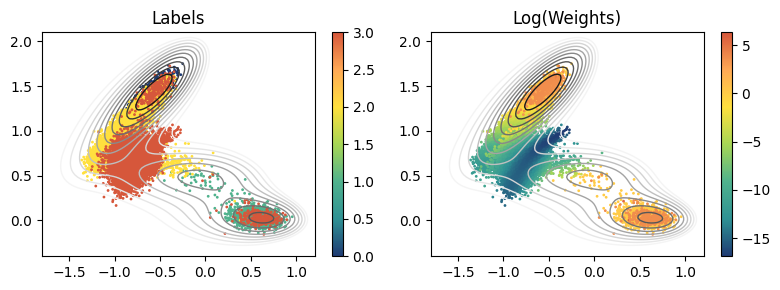

In [44]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')

plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=dataset['labels'], s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=torch.log(dataset['weights']), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

## Initialize trainer and fit model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type           | Params | Mode  | In sizes | Out sizes
--------------------------------------------------------------------------
0 | loss_fn | CommittorLoss  | 0      | train | ?        | ?        
1 | nn      | FeedForward    | 1.2 K  | train | [1, 2]   | [1, 1]   
2 | sigmoid | Custom_Sigmoid | 0      | train | [1, 1]   | [1, 1]   
--------------------------------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
/home/etrizio/Bin/miniconda3/envs/mlcolvar_dev/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_num=4]


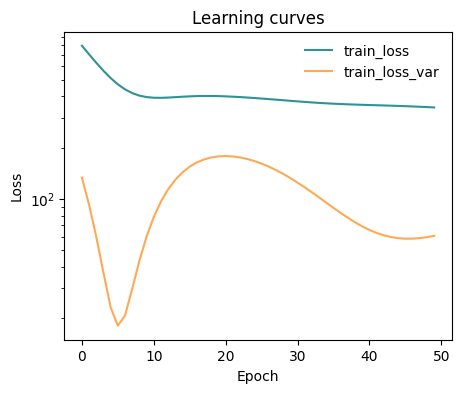

In [27]:
from mlcolvar.utils.trainer import MetricsCallback

# define callbacks
metrics = MetricsCallback()

# initialize trainer, for testing the number of epochs is low, change this to something like 4/5000 at least
trainer = lightning.Trainer(callbacks=[metrics], max_epochs=50, logger=None, enable_checkpointing=False,
            limit_val_batches=0, num_sanity_val_steps=0, accelerator='cpu'
        )

# fit model
trainer.fit(model, datamodule)

# plot metrics
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss', 'train_loss_var'],
                  colors=['fessa1','fessa5'],
                  yscale='log')

## Visualize results

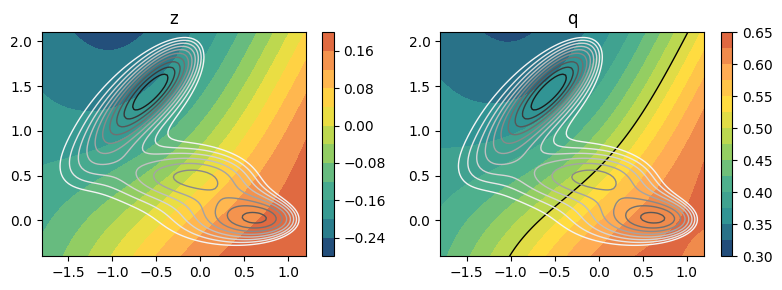

In [31]:
# save sigmoid activation of output layer to go from z to q
import copy
Sigmoid = copy.copy(model.sigmoid)

fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot z --> sigmoid activation off
ax = axs[0]
ax.set_title('z')
model.sigmoid = None
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)

# plot q --> sigmoid activation on
ax = axs[1]
ax.set_title('q')
model.sigmoid = Sigmoid
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()

## Visualize Kolmogorov bias 

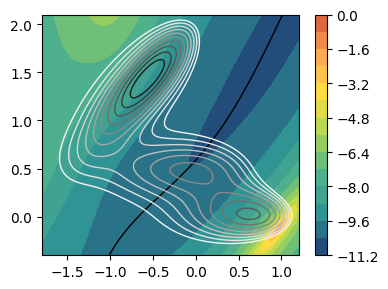

In [30]:
from mlcolvar.cvs.committor.utils import KolmogorovBias

model_bias = KolmogorovBias(input_model=model, beta=beta, epsilon=1e-6, lambd=1)

fig, ax = plt.subplots(1,1,figsize=(4,3))
plot_isolines_2D(model_bias, ax=ax, colorbar=True, allow_grad=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()

## Export model with tracing

In [29]:
traced_model = model.to_torchscript(file_path='test_trace.pt', method='trace')

## OPTIONAL: Apply preprocessing to compute descriptors 
You can add preprocessing module to the model by `model.preprocessing = Module`.

Here we just create a mock preprocessing that swaps `p.x` and `p.y` 

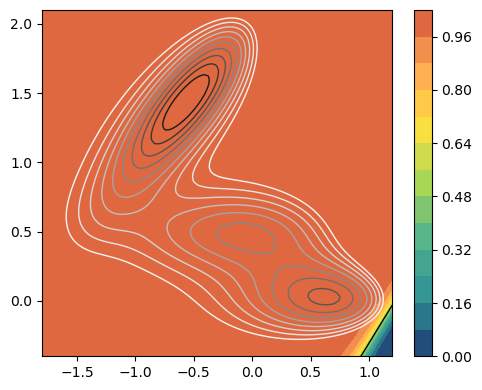

In [11]:
from mlcolvar.core.transform import PairwiseDistances

class UselsessPreprocessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = torch.flip(x, (1, ))
        return x

Prep = UselsessPreprocessing()

inp = dataset['data'][0:2]

prep_inp = Prep(inp)

model.preprocessing = Prep
fig, ax = plt.subplots(1,1,figsize=(5,4))
plot_isolines_2D(model, ax=ax, colorbar=True)
plot_isolines_2D(model, ax=ax, colorbar=True, levels=[0.5], mode='contour', linewidths=1)
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
plt.tight_layout()
plt.show()
